# Credit Card Fraud Detection Using Autoencoder
 - Algorithm: Autoencoder
 - Tool: SAS DLPy
 - Deployment:  SAS Model Manager and SAS Intelligent Decisioning

## Declare required dependencies

In [43]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 111)
import numpy as np
import pickle

import tensorflow as tf
import pickle
from sklearn.metrics import accuracy_score


from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [44]:
import swat
swat.options.cas.print_messages = True

import os
os.environ['CAS_CLIENT_SSL_CA_LIST'] = '/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem'

conn=swat.CAS("eeclxvm068.exnet.sas.com",5570,'gegrab','Demopw123', caslib='gegrab_s')

## Data ingestion

In [45]:
df = pd.read_csv('Data_orig/creditcard.csv')
customer_id = np.random.randint(1000000,5000000, len(df))
transaction_date = pd.date_range(start='1/1/2020', periods=len(df), freq='MIN') 
df.insert(0, 'customer_id', customer_id)
df.insert(1, 'transaction_date', transaction_date)


df.rename({'Time':'Counter'}, axis = 1, inplace = True)




dfsample = df.sample(frac=0.1)

dfsample.to_csv('Data_orig/creditcard_10.csv', index=False)
 
# features =df[df.Class==0]
# features.drop(['customer_id', 'transaction_date', 'Class','Counter'], axis=1)
 
 
# castbl = conn.upload_frame(features, casout=dict(name='fraud', replace=True))
# indata="fraud"

 
 
#print(castbl.head(111))
df

,customer_id,transaction_date,Counter,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,4571372,2020-01-01 00:00:00,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1460833,2020-01-01 00:01:00,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,3045224,2020-01-01 00:02:00,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,2954691,2020-01-01 00:03:00,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2571866,2020-01-01 00:04:00,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1791692,2020-07-16 18:42:00,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,1159140,2020-07-16 18:43:00,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1384639,2020-07-16 18:44:00,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,4047559,2020-07-16 18:45:00,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Data exploration

- Variables V1 - V30 are Derived  Principal Components Analysis (PCA)

In [46]:
df['V1'].value_counts()

 2.055797    77
 1.245674    77
 2.053311    62
 1.302378    60
 2.040211    53
             ..
 1.172238     1
-1.459083     1
-0.938907     1
 1.375417     1
-0.533413     1
Name: V1, Length: 275653, dtype: int64

In [47]:
print(df.shape)
print(df.describe())
print(list(df))


(284807, 33)
        customer_id        Counter            V1            V2            V3  \
count  2.848070e+05  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.998355e+06   94813.859575  1.759061e-12 -8.251130e-13 -9.654937e-13   
std    1.154378e+06   47488.145955  1.958696e+00  1.651309e+00  1.516255e+00   
min    1.000037e+06       0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01   
25%    1.999667e+06   54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01   
50%    2.996802e+06   84692.000000  1.810880e-02  6.548556e-02  1.798463e-01   
75%    3.998167e+06  139320.500000  1.315642e+00  8.037239e-01  1.027196e+00   
max    4.999999e+06  172792.000000  2.454930e+00  2.205773e+01  9.382558e+00   

                 V4            V5            V6            V7            V8  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   8.321385e-13  1.649999e-13  4.248366e-13 -3.054600e-13  8.777971e-14   
std    1.415869e+00  1.380247

## Is there any data missing ?

In [48]:
df.isnull().values.any()
 

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

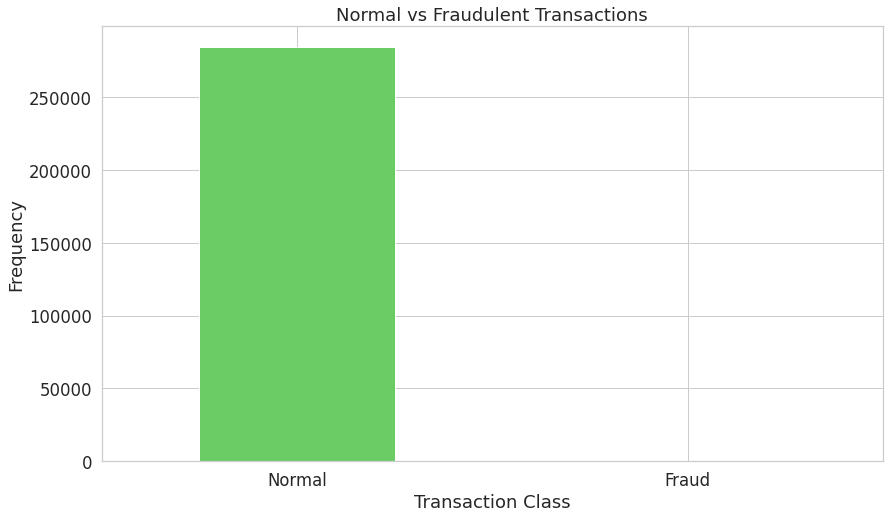

In [49]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulent Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Our dataset is very highly imbalanced in favour of negative(0, i.e normal) class. This requires further data exploration

In [68]:
fraudsDF = df[df.Class == 1]
normalDF = df[df.Class == 0]

fraudssample =fraudsDF.iloc[0:5].drop(['Class'], axis=1)
normalsample =normalDF.iloc[0:5].drop(['Class'], axis=1)

df_test=pd.concat([normalsample, fraudssample])

 

 
#df_test.to_csv('Data_orig/creditcard_fraud_test_1.csv', index=False)

 


,customer_id,transaction_date,Counter,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,4571372,2020-01-01 00:00:00,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1460833,2020-01-01 00:01:00,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,3045224,2020-01-01 00:02:00,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,2954691,2020-01-01 00:03:00,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2571866,2020-01-01 00:04:00,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
541,4668285,2020-01-01 09:01:00,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00
623,1299774,2020-01-01 10:23:00,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
4920,4141011,2020-01-04 10:00:00,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93
6108,4669259,2020-01-05 05:48:00,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00
6329,3990281,2020-01-05 09:29:00,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00


In [51]:
fraudsDF.shape

(492, 33)

In [52]:
normalDF.shape

(284315, 33)

Let's now look at the amount of money involved across two classes

In [53]:
fraudsDF.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [54]:
normalDF.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [55]:
normalDF.Amount.max(), normalDF.Amount.min(), normalDF.Amount.value_counts()
print(normalDF['Amount']) 

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284315, dtype: float64


Graphically speaking ...`

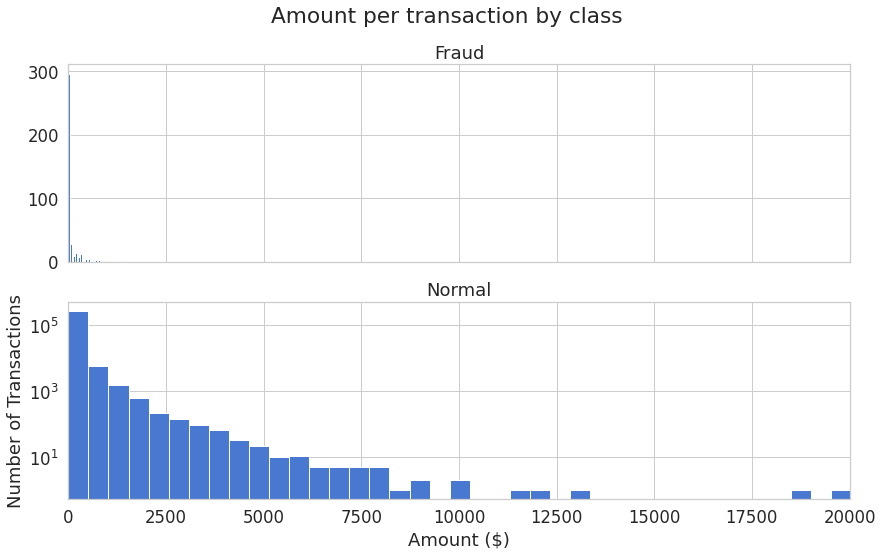

In [56]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Does time of transaction have any bearing on fraudulent activity

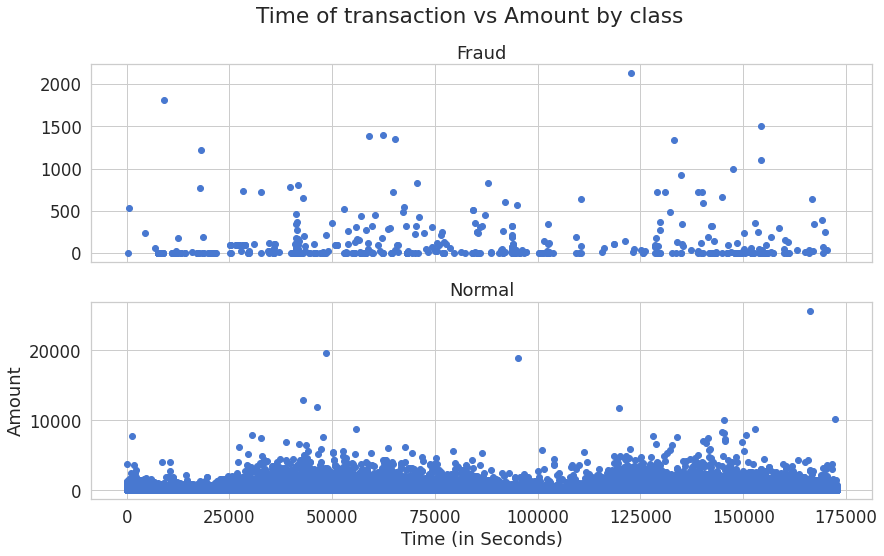

In [57]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Counter, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Counter
            , normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

So, it is clear that time of transaction has no bearing on the fraudulent activity.

# Preprocessing

Since, as shown above, time of transaction has no bearing on fraudulent activity, this feature is not going to contribute to model learning. Hence we can drop it.

In [58]:
transactionData = df.drop(['Counter', 'customer_id', 'transaction_date'], axis=1)
transactionData

scaler =StandardScaler()

feature=transactionData.Amount
print(feature)
feature = scaler.fit_transform(feature.values.reshape(-1,1))
print(feature)
 

pickle.dump(scaler, open('/sasinside/userdata/gegrab/resources/hmeq/fraud_pytorch_scaler.pickle', 'wb'))

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284807, dtype: float64
[[ 0.24496426]
 [-0.34247454]
 [ 1.16068593]
 ...
 [-0.0818393 ]
 [-0.31324853]
 [ 0.51435531]]


Also let us standardize the feature Amount.

In [59]:
 
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1,1))

transactionData.iloc[43428]

V1       -16.526507
V2         8.584972
V3       -18.649853
V4         9.505594
V5       -13.793819
V6        -2.832404
V7       -16.701694
V8         7.517344
V9        -8.507059
V10      -14.110184
V11        5.299236
V12      -10.834006
V13        1.671120
V14       -9.373859
V15        0.360806
V16       -9.899247
V17      -19.236292
V18       -8.398552
V19        3.101735
V20       -1.514923
V21        1.190739
V22       -1.127670
V23       -2.358579
V24        0.673461
V25       -1.413700
V26       -0.462762
V27       -2.018575
V28       -1.042804
Amount     1.102834
Class      1.000000
Name: 43428, dtype: float64

### Split the dataset in training and test datasets

We split the dataset as Training=80% and Test=20%. Training dataset will have only normal transactions and test dataset will have both normal and fraudulent transactions.

In [60]:
transactionData.iloc[43428]

 
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test2 = X_test
X_test = X_test.drop(['Class'], axis=1)

 


inputs = list(X_train)
print(inputs)

inputs_test = list(X_test)
print(inputs_test)
 

castbl_X_train = conn.upload_frame(X_train, casout=dict(name='X_train', replace=True))
indata_X_train="X_train"


castbl_X_test = conn.upload_frame(X_test, casout=dict(name='X_test', replace=True))
indata_X_test="X_test"

# castbl_y_test = conn.upload_frame(y_test, casout=dict(name='y_test', replace=True))
# indata_y_test="y_test"

 

X_train = X_train.values.astype('float32')
 
X_test = X_test.values.astype('float32')
y_test = y_test.values.astype('float32')
 

 


['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
NOTE: Cloud Analytic Services made the uploaded file available as table X_TRAIN in caslib gegrab_s.
NOTE: The table X_TRAIN has been created in caslib gegrab_s from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table X_TEST in caslib gegrab_s.
NOTE: The table X_TEST has been created in caslib gegrab_s from binary data uploaded to Cloud Analytic Services.


In [61]:
# conn.tableinfo()
 

## Model
We will build the autoencoder consisting of 4 fully connected layers with 14,7,7,29 neurons. First 2 layers act as encoder and last 2 layers act as decoder. Note last layer has 29 nodes corresponding to 29 feature in the input data item.

In [62]:
#We use the SAS Deep Learning toolkit to create an empty neural network model that we intend to train as an autoencoder
conn.loadactionset('deepLearn')
conn.deepLearn.buildModel(
    model=dict(name='sas_fraud_autoencoder',replace=True),
    type = 'DNN'
)

conn.deepLearn.addLayer(
    model='sas_fraud_autoencoder',
    layer=dict(type='INPUT'),  
    #layer=dict(type='INPUT', std='std'),
    replace=True,
    name='data'
)

conn.deepLearn.addLayer(
    model='sas_fraud_autoencoder',
    layer=dict(type='FC',n=14),
    replace=True,
    srcLayers='data',
    name='encoding'
)


conn.deepLearn.addLayer(
    model='sas_fraud_autoencoder',
    layer=dict(type='FC',n=7),
    replace=True,
    srcLayers='encoding',
    name='bottleneck'
)

conn.deepLearn.addLayer(
    model='sas_fraud_autoencoder',
    layer=dict(type='FC',n=14),
    replace=True,
    srcLayers='bottleneck',
    name='decoding'
)

 

conn.deepLearn.addLayer(
    model='sas_fraud_autoencoder',
    layer=dict(type='OUTPUT'),
    replace=True,
    srcLayers='decoding',
    name='output'
)

NOTE: Added action set 'deepLearn'.


,casLib,Name,Rows,Columns,casTable
0,gegrab_s,sas_fraud_autoencoder,59,5,"CASTable('sas_fraud_autoencoder', caslib='gegr..."


In [63]:
conn.deepLearn.dlTrain(
    table = dict(name=castbl_X_train),
    inputs = inputs,
    modelTable='sas_fraud_autoencoder',
    modelWeights=dict(name='sas_fraud_autoencoder_trained_weights',replace=True),
#These optimizer settings end up being very important for the functionality of the anomaly detection model.
#Changing these settings can allow you to build a model that better reduces fit error
    optimizer = dict(miniBatchSize=60, maxEpochs=90,  loglevel=1,
                     algorithm=dict(method='adam'))
)


conn.deepLearn.dlExportModel(
    casOut=dict(name='SAS_FRAUD_AUTOENCODER_ASTORE', replace=True),
    initWeights='sas_fraud_autoencoder_trained_weights',
    modelTable='sas_fraud_autoencoder',
    layerImageType="WIDE",
    layers=['output'],
     
)


 

NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 1072.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  The total number of workers is 5.
NOTE:  The total number of threads on each worker is 8.
NOTE:  The total mini-batch size per thread on each worker is 60.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 2400.
NOTE:  The optimization reached the maximum number of epochs.
NOTE:  The total time is      50.80 (s).
NOTE: 22980 bytes were written to the table "SAS_FRAUD_AUTOENCODER_ASTORE" in the caslib "gegrab_s".


,casLib,Name
0,gegrab_s,SAS_FRAUD_AUTOENCODER_ASTORE


In [64]:
conn.deepLearn.dlExportModel(
    casOut=dict(name='SAS_FRAUD_AUTOENCODER_ASTORE', replace=True),
    initWeights='sas_fraud_autoencoder_trained_weights',
    modelTable='sas_fraud_autoencoder',
    layerImageType="WIDE",
    
    layers=['output'],
     
)


# conn.table.promote('sas_fraud_autoencoder_astore', drop=True)
# conn.table.promote('sas_fraud_autoencoder', drop=True)
# conn.table.promote('sas_fraud_autoencoder_trained_weights', drop=True)


NOTE: 22980 bytes were written to the table "SAS_FRAUD_AUTOENCODER_ASTORE" in the caslib "gegrab_s".


,casLib,Name
0,gegrab_s,SAS_FRAUD_AUTOENCODER_ASTORE


In [65]:
# Score Training data and compare to actuals to determine threshold
conn.loadactionset('deepLearn')
conn.deepLearn.dlScore(
    table=castbl_X_train,
    model='sas_fraud_autoencoder',
    initWeights='sas_fraud_autoencoder_trained_weights',
    copyVars=inputs_test,
    casout=dict(name='scored_sas_fraud_autoencoder', replace=True),
#The following syntax is important for using the results of the autoencoder model and is discussed below
    layerOut=dict(name='sas_fraud_layers',replace=True),
    layerImageType="WIDE",
    layers=['output']
)

training= conn.CASTable('sas_fraud_layers').to_frame() 
training_actuals = training[training.columns[0:29]]
training_predict = training[training.columns[29:]]
 

reconstruction_errors = tf.keras.losses.msle(training_predict, training_actuals)
threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
print(threshold)

pickle.dump(threshold, open('/sasinside/userdata/gegrab/resources/hmeq/sas_fraud_anomaly_threshold.pickle', 'wb'))

NOTE: Added action set 'deepLearn'.


2022-06-13 15:44:14.352688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-13 15:44:14.352738: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-13 15:44:14.352765: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eeclxvm068.exnet.sas.com): /proc/driver/nvidia/version does not exist
2022-06-13 15:44:14.353242: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.08832281889485119


In [66]:
def execute(customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount):
    "Output: FRAUD_FLAG, errors, threshold, max_credit_flag"
    
    import pickle
    import tensorflow as tf
    import pandas as pd
    import numpy as np 
    import swat
    import os
    
    os.environ['CAS_CLIENT_SSL_CA_LIST'] = '/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem'

    conn=swat.CAS("eeclxvm068.exnet.sas.com",5570,'gegrab','Demopw123', caslib='gegrab_s')
    
    inputArray = pd.DataFrame([[customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount]],
                              columns = ["customer_id", "transaction_date","Counter", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"]
                               )    
    
    scaler2 = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/fraud_pytorch_scaler.pickle', 'rb'))
    feature2 = inputArray.Amount
   
    inputArray.drop(['Amount', 'customer_id', 'transaction_date', 'Counter'], axis=1, inplace=True)
    AmountScaled = pd.DataFrame(scaler2.transform(feature2.values.reshape(-1,1)))
    inputArray.insert(28, 'Amount', AmountScaled)
    
    threshold = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/sas_fraud_anomaly_threshold.pickle', 'rb'))

    
    castest = conn.upload_frame(inputArray, casout=dict(name='inputArray', replace=True))
    
    conn.loadactionset('deepLearn')
    conn.deepLearn.dlScore(
    table=castest,
    model='sas_fraud_autoencoder',
    initWeights='sas_fraud_autoencoder_trained_weights',
    layerOut=dict(name='sas_fraud_layers',replace=True),
    layerImageType="WIDE",
    layers=['output']
    )

    predictions= conn.CASTable('sas_fraud_layers').values
    inputArray = inputArray.values
    
    errors = tf.keras.losses.msle(predictions, inputArray)
    features= np.subtract(predictions, inputArray)**2
    credit_flag= 'V' + str(int(np.where(features ==np.amax(features))[1])) 
    
    
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)

     
    FRAUD_FLAG =float(preds)
    errors=float(errors)
    threshold=float(threshold)
    
    if FRAUD_FLAG == 1:
        max_credit_flag = credit_flag
    else:
        max_credit_flag= ' '

    return (FRAUD_FLAG, errors, threshold, max_credit_flag)

In [67]:
import pandas as pd
X_test2 = pd.read_csv('Data_orig/creditcard_fraud_test_1.csv')

for i in range(10):
    print(execute(**X_test2.iloc[i]))
 


NOTE: Cloud Analytic Services made the uploaded file available as table INPUTARRAY in caslib gegrab_s.
NOTE: The table INPUTARRAY has been created in caslib gegrab_s from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'deepLearn'.
NOTE: Due to data distribution, miniBatchSize has been limited to 1.
(0.0, 0.01590925394394604, 0.08832281889485119, ' ')
NOTE: Cloud Analytic Services made the uploaded file available as table INPUTARRAY in caslib gegrab_s.
NOTE: The table INPUTARRAY has been created in caslib gegrab_s from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'deepLearn'.
NOTE: Due to data distribution, miniBatchSize has been limited to 1.
(0.0, 0.009541362104739179, 0.08832281889485119, ' ')
NOTE: Cloud Analytic Services made the uploaded file available as table INPUTARRAY in caslib gegrab_s.
NOTE: The table INPUTARRAY has been created in caslib gegrab_s from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 

In [69]:
score_code = """
def execute(customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount):
    "Output: FRAUD_FLAG, errors, threshold, max_credit_flag"
    
    import pickle
    import tensorflow as tf
    import pandas as pd
    import swat
    import os
    
    os.environ['CAS_CLIENT_SSL_CA_LIST'] = '/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem'

    conn=swat.CAS("eeclxvm068.exnet.sas.com",5570,'gegrab','Demopw123', caslib='gegrab_s')
    
    inputArray = pd.DataFrame([[customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount]],
                              columns = ["customer_id", "transaction_date","Counter", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"]
                               )    
    
    scaler2 = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/fraud_pytorch_scaler.pickle', 'rb'))
    feature2 = inputArray.Amount
   
    inputArray.drop(['Amount', 'customer_id', 'transaction_date', 'Counter'], axis=1, inplace=True)
    AmountScaled = pd.DataFrame(scaler2.transform(feature2.values.reshape(-1,1)))
    inputArray.insert(28, 'Amount', AmountScaled)
    
    threshold = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/sas_fraud_anomaly_threshold.pickle', 'rb'))

    
    castest = conn.upload_frame(inputArray, casout=dict(name='inputArray', replace=True))
    
    conn.loadactionset('deepLearn')
    conn.deepLearn.dlScore(
    table=castest,
    model='sas_fraud_autoencoder',
    initWeights='sas_fraud_autoencoder_trained_weights',
    layerOut=dict(name='sas_fraud_layers',replace=True),
    layerImageType="WIDE",
    layers=['output']
    )

    predictions= conn.CASTable('sas_fraud_layers').values
    inputArray = inputArray.values
    
    errors = tf.keras.losses.msle(predictions, inputArray)
    features= np.subtract(predictions, inputArray)**2
    credit_flag= 'V' + str(int(np.where(features ==np.amax(features))[1])) 
    
    
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)

     
    FRAUD_FLAG =float(preds)
    errors=float(errors)
    threshold=float(threshold)
    
    if FRAUD_FLAG == 1:
        max_credit_flag = credit_flag
    else:
        max_credit_flag= ' '

    return (FRAUD_FLAG, errors, threshold, max_credit_flag)"""


f = open('Data_orig/Fraud_SAS_DLPy_Anomaly_MAX.py',"w+")
f.write(score_code)
f.close()